In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import torchaudio
import soundfile as sf
import numpy as np

import os
from tqdm.notebook import tqdm
from pathlib import Path

import random
from PIL import Image

import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt

In [2]:
# Note: this notebook requires torch >= 1.10.0
torch.__version__

'1.13.1'

In [3]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Data preparation

In [4]:
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in tqdm(os.walk(dir_path)):
    print(f"There are {len(dirnames)} directories and {len(filenames)} audios in '{dirpath}'.")

In [5]:
source_path=Path("./Source")
walk_through_dir(source_path)

0it [00:00, ?it/s]

There are 4 directories and 0 audios in 'Source'.
There are 0 directories and 6 audios in 'Source\451 Градус по Фаренгейту'.
There are 0 directories and 4 audios in 'Source\ГробницаСаргераса'.
There are 0 directories and 1 audios in 'Source\Из жихни щепок'.
There are 0 directories and 13 audios in 'Source\Планета Вода'.


In [6]:
# Setup train and testing paths
train_dir = source_path / "train"
test_dir = source_path / "test"

train_dir, test_dir

(WindowsPath('Source/train'), WindowsPath('Source/test'))

## Visualize an audio

In [7]:
# Set seed
random.seed(42) # <- try changing this and see what happens

In [8]:
# 1. Get all audios paths (* means "any combination")
audio_path_list = list(source_path.glob("*/*.mp3"))

# 2. Get random audio path
random_audio_path = random.choice(audio_path_list)

# 3. Get audio class from path name (the audio class is the name of the directory where the audio is stored)
audio_class = random_audio_path.parent.stem

# 4. Open image
audio,sr = librosa.core.load(random_audio_path, sr=20480)

# 5. Print metadata
print(f"Random audio path: {random_audio_path}")
print(f"Audio class: {audio_class}")
print(f"Audio sample rate: {sr}") 
print(f"Audio data length: {len(audio)}")
print(f"Audio duration in min: {len(audio)/sr/60}")

Random audio path: Source\Планета Вода\10 Планета Вода .mp3
Audio class: Планета Вода
Audio sample rate: 20480
Audio data length: 24940862
Audio duration in min: 20.29692545572917


In [9]:
#Listen to first 30 sec of the audio
ipd.Audio(audio[:30*sr], rate = sr)

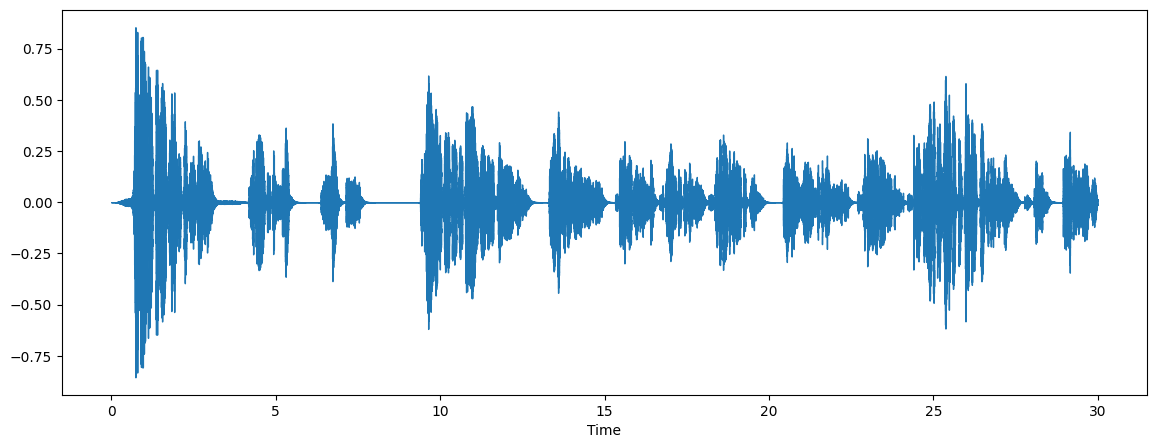

In [10]:
#View of 30 sec of the audio
plt.figure(figsize=(14, 5))
librosa.display.waveshow(audio[:30*sr], sr=sr)

## Transforming data

# Dataset creation

In [4]:
# Set the directory path for the audiobooks
audio_dir = Path("./Source")

In [5]:
# Set the directory path for saving the audio slices
output_dir = Path("./ABDataset")


In [6]:
# Set the duration of each audio slice in seconds
slice_duration = 2 * 60
#sr=8000

# Create a list to store the data for the csv file
data = []

In [7]:
k=0
# Loop through each folder in the audio directory
for folder_name in tqdm(os.listdir(audio_dir)):
    folder_path = os.path.join(audio_dir, folder_name)
    
    # Skip if the folder is not a directory
    if not os.path.isdir(folder_path):
        continue
    
    # Get the book number from the folder name
    k=k+1
    book_number = k
    p=0
    endtime=0
    
    # Loop through each audio file in the folder
    for file_name in tqdm(os.listdir(folder_path)):
        file_path = os.path.join(folder_path, file_name)
        
        # Skip if the file is not an audio file
        if not file_name.endswith(".mp3"):
            continue
        
        # Open the audio file
        audio,sr = librosa.core.load(file_path, sr=None)
        
        # Calculate the number of slices
        num_slices = len(audio) // (slice_duration*sr)
        
        # Loop through each slice and save it to the output directory
        for i in tqdm(range(num_slices)):
            p=p+1
            start_time = endtime
            end_time = start_time + slice_duration
            endtime=end_time
            slice_audio = audio[i*slice_duration*sr:min((i + 1) * slice_duration, len(audio))*sr]
            slice_path = os.path.join(output_dir, f"fold{book_number}", f"{file_name}_{i}.mp3")
            os.makedirs(os.path.dirname(slice_path), exist_ok=True)
            sf.write(slice_path, slice_audio, sr, format='MP3')
            
            # Add data to the csv file
            data.append({
                "book_number": book_number,
                "book_name": folder_name,
                "piece_number": p,
                "start_time": start_time,
                "end_time": end_time,
                "path": slice_path,
                "id": f"{book_number}_{p}"
            })

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

In [8]:
# Create a pandas dataframe from the data and save it to a csv file
df = pd.DataFrame(data)
df.to_csv(output_dir / Path("database.csv"), index=False, header=True, encoding='utf-8')

# Working with Dataset

In [4]:
class AudioBooksDataset(Dataset):

    def __init__(self, annotations_file, audio_dir, transformation, target_sample_rate, num_samples):
        self.annotations = pd.read_csv(annotations_file)
        self.audio_dir = audio_dir
        self.transformation = transformation
        self.target_sample_rate=target_sample_rate
        self.num_samples=num_samples
        
    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        audio_sample_path = self._get_audio_sample_path(index)
        label = self._get_audio_sample_label(index)
        signal, sr = torchaudio.load(audio_sample_path)
        #signal -> (num_channels,samples)
        signal=self._resample_if_necessary(signal,sr)
        signal= self._mix_down_if_necessary(signal)
        signal = self._cut_if_necessary(signal)
        signal = self._right_pad_if_necessary(signal)
        signal=self.transformation(signal)
        signal=signal.squeeze()
        signal= signal.reshape(1, 221534)
        signal=abs(signal)
        return signal, label
    
    def _cut_if_necessary(self, signal):
        #signal -> Tensor (1, num_samples)
        if signal.shape[1] > self.num_samples:
            signal = signal[:, :self.num_samples]
        return signal
    
    def _right_pad_if_necessary(self, signal):
        length_signal = signal.shape[1]
        if length_signal < self.num_samples:
            num_missing_samples = self.num_samples - length_signal
            last_dim_padding = (0, num_missing_samples)
            signal = torch.nn.functional.pad(signal, last_dim_padding)
        return signal
    
    def _resample_if_necessary(self, signal, sr):
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate)
            signal = resampler(signal)
        return signal

    def _mix_down_if_necessary(self, signal):
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal
    
    def _get_audio_sample_path(self, index):
        path = self.annotations.iloc[index, 5]
        return path

    def _get_audio_sample_label(self, index):
        return self.annotations.iloc[index, 6]

In [5]:
n_fft=512
win_length=512
hop_length=int(win_length/2)

In [6]:
spectrogram = torchaudio.transforms.Spectrogram(
        n_fft=n_fft,
        win_length=win_length,
        hop_length=hop_length,
        power=None,
        #onesided = False 
    )

In [7]:
inverse_spectrogram=torchaudio.transforms.InverseSpectrogram(
        n_fft=n_fft,
        win_length=win_length,
        hop_length=hop_length
    )

In [8]:
def create_data_loader(train_dataset, batch_size):
    train_dataloader=DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
    return train_dataloader

In [9]:
ANNOTATIONS_FILE = Path("./ABDataset/database.csv")
AUDIO_DIR = Path("./ABDataset")
SAMPLE_RATE=44100
NUM_SAMPLES = 44100*5 #5 sec of audio

In [10]:
train_dataset=AudioBooksDataset(ANNOTATIONS_FILE, AUDIO_DIR, spectrogram, SAMPLE_RATE,NUM_SAMPLES)
print(f"There are {len(train_dataset)} samples in the dataset.")

There are 498 samples in the dataset.


In [11]:
batch_size = 250
train_dataloader = create_data_loader(train_dataset,batch_size)

In [12]:
for batch in train_dataloader:
    print(batch)
    break

[tensor([[[4.9265e+00, 2.7850e+00, 2.4018e+00,  ..., 1.1854e-05,
          2.7120e-06, 2.2196e-03]],

        [[3.2456e-02, 2.4125e-01, 1.6361e-01,  ..., 5.2154e-07,
          5.9605e-08, 3.9965e-05]],

        [[6.5184e+00, 2.8544e+00, 3.8489e+00,  ..., 1.9670e-06,
          2.6822e-07, 1.3212e-03]],

        ...,

        [[1.9112e+00, 2.5050e+00, 2.1999e+00,  ..., 6.1989e-06,
          7.8082e-06, 2.8610e-06]],

        [[1.0767e+00, 2.6257e-02, 8.5455e-01,  ..., 2.5630e-06,
          3.7998e-06, 7.5519e-05]],

        [[7.1517e+00, 5.4200e+00, 1.1078e+00,  ..., 1.9073e-05,
          1.6212e-05, 4.5776e-05]]]), ('1_151', '1_80', '1_110', '4_55', '1_82', '3_27', '4_54', '1_98', '1_33', '1_159', '2_44', '3_10', '1_75', '4_89', '1_56', '2_12', '1_162', '1_96', '1_71', '1_134', '3_53', '1_65', '2_6', '3_7', '4_197', '4_16', '4_81', '4_157', '4_84', '3_25', '1_100', '4_91', '1_166', '4_13', '3_18', '1_173', '1_16', '4_173', '4_47', '1_63', '1_34', '4_106', '4_134', '4_99', '4_148', '4_14

In [13]:
batch[0].shape, len(batch[1])

(torch.Size([250, 1, 221534]), 250)

In [14]:
class AE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.encoder_hidden_layer = nn.Linear(
            in_features=kwargs["input_shape"], out_features=64
        )
        self.encoder_output_layer = nn.Linear(
            in_features=64, out_features=64
        )
        self.decoder_hidden_layer = nn.Linear(
            in_features=64, out_features=64
        )
        self.decoder_output_layer = nn.Linear(
            in_features=64, out_features=kwargs["input_shape"]
        )

    def forward(self, features):
        activation = self.encoder_hidden_layer(features)
        activation = torch.relu(activation)
        code = self.encoder_output_layer(activation)
        code = torch.relu(code)
        activation = self.decoder_hidden_layer(code)
        activation = torch.relu(activation)
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.relu(activation)
        return reconstructed

In [15]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = AE(input_shape=221534).to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

# mean-squared error loss
criterion = nn.MSELoss()

In [16]:
def train(model, criterion, optimizer, 
          train_dataloader, num_epochs):
    
    train_losses = np.zeros(num_epochs)

    train_accuracy_arr = np.zeros(num_epochs)

    for i_epoch in tqdm(range(num_epochs)):
        train_loss = 0

        train_accuracy = 0

        # train step
        #model.train()
        for batch in train_dataloader:
            batch[0]=batch[0].to(device)
            X = batch[0].to(device)
            
            # model forward-pass
            preds = model(X)

            # model backward-pass
            optimizer.zero_grad()
            loss = criterion(preds, batch[0])
            loss.backward()
            optimizer.step()

            # save loss and accuracy
            train_loss += loss.detach().cpu().numpy()
            train_accuracy += (preds.detach() == batch[0]).cpu().numpy().mean()

        train_loss /= len(train_dataloader)
        train_accuracy /= len(train_dataloader)
        train_losses[i_epoch] = train_loss
        train_accuracy_arr[i_epoch] = train_accuracy

    return train_losses, train_accuracy_arr

In [17]:
model_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of trainable parameters: {model_total_params}')

Number of trainable parameters: 28586270


In [18]:
train_losses, \
    train_accuracy_arr= train(model, criterion=criterion, 
                              optimizer=optimizer,
                              train_dataloader=train_dataloader,  
                              num_epochs=60)

  0%|          | 0/60 [00:00<?, ?it/s]

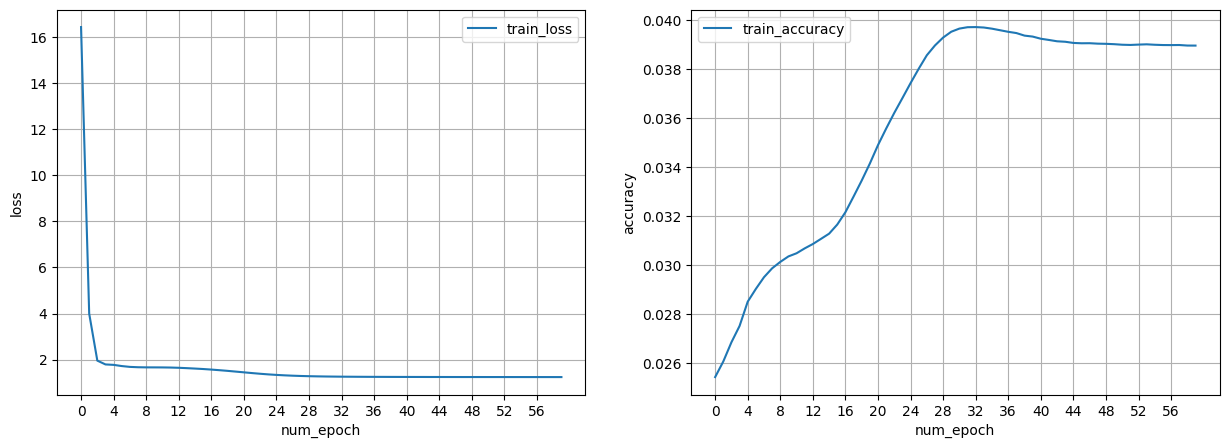

In [19]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))

ax[0].plot(np.arange(train_losses.shape[0]), train_losses, label='train_loss')
ax[0].set_xticks(np.arange(0, train_losses.shape[0], 4))
ax[0].set_xlabel('num_epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[0].grid()

ax[1].plot(np.arange(train_accuracy_arr.shape[0]), train_accuracy_arr, 
           label='train_accuracy')
ax[1].set_xticks(np.arange(0, train_accuracy_arr.shape[0], 4))
ax[1].set_xlabel('num_epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()
ax[1].grid()
plt.show()

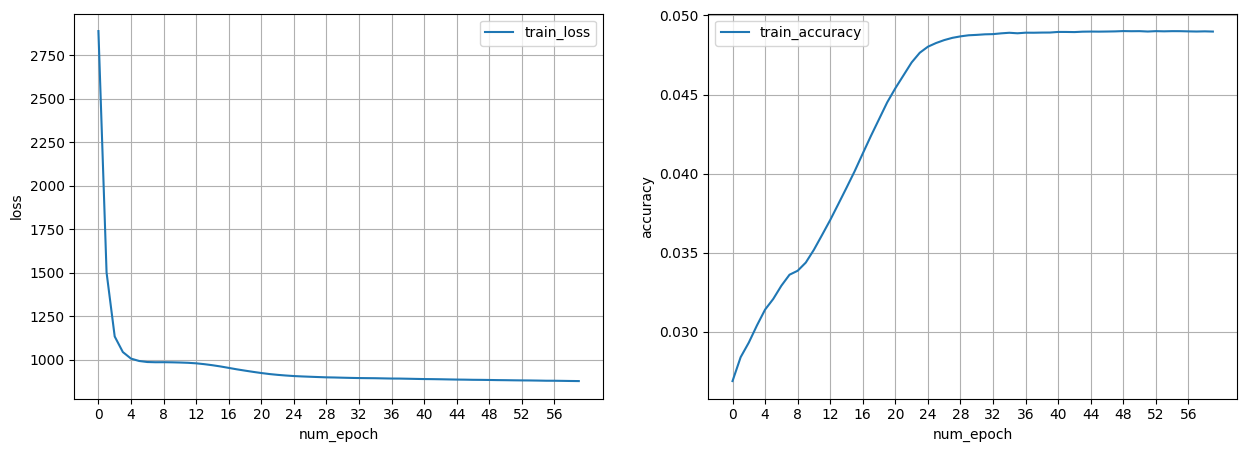

In [17]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))

ax[0].plot(np.arange(train_losses.shape[0]), train_losses, label='train_loss')
ax[0].set_xticks(np.arange(0, train_losses.shape[0], 4))
ax[0].set_xlabel('num_epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[0].grid()

ax[1].plot(np.arange(train_accuracy_arr.shape[0]), train_accuracy_arr, 
           label='train_accuracy')
ax[1].set_xticks(np.arange(0, train_accuracy_arr.shape[0], 4))
ax[1].set_xlabel('num_epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()
ax[1].grid()
plt.show()

In [18]:
print(f'Best train_loss = {train_losses.min()}')
print(f'Best train_accuracy = {train_accuracy_arr.max()}')

Best train_loss = 877.5303649902344
Best train_accuracy = 0.0490103429257918


In [85]:
class Test(Dataset):

    def __init__(self, annotations_file, audio_dir, transformation, target_sample_rate, num_samples):
        self.annotations = pd.read_csv(annotations_file)
        self.audio_dir = audio_dir
        self.transformation = transformation
        self.target_sample_rate=target_sample_rate
        self.num_samples=num_samples
        
    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        audio_sample_path = self._get_audio_sample_path(index)
        label = self._get_audio_sample_label(index)
        signal, sr = torchaudio.load(audio_sample_path)
        #signal = signal.to(torch.complex64) 
        #signal -> (num_channels,samples)
        signal=self._resample_if_necessary(signal,sr)
        signal= self._mix_down_if_necessary(signal)
        signal = self._cut_if_necessary(signal)
        signal = self._right_pad_if_necessary(signal)
        signal=self.transformation(signal)
        return signal, label
    
    def _cut_if_necessary(self, signal):
        #signal -> Tensor (1, num_samples)
        if signal.shape[1] > self.num_samples:
            signal = signal[:, :self.num_samples]
        return signal
    
    def _right_pad_if_necessary(self, signal):
        length_signal = signal.shape[1]
        if length_signal < self.num_samples:
            num_missing_samples = self.num_samples - length_signal
            last_dim_padding = (0, num_missing_samples)
            signal = torch.nn.functional.pad(signal, last_dim_padding)
        return signal
    
    def _resample_if_necessary(self, signal, sr):
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate)
            signal = resampler(signal)
        return signal

    def _mix_down_if_necessary(self, signal):
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal
    
    def _get_audio_sample_path(self, index):
        path = self.annotations.iloc[index, 5]
        return path

    def _get_audio_sample_label(self, index):
        return self.annotations.iloc[index, 6]

In [86]:
p=Test(ANNOTATIONS_FILE, AUDIO_DIR, spectrogram, SAMPLE_RATE,NUM_SAMPLES)

In [88]:
test = p[4]

print(test[0].shape, test[0])
signal=inverse_spectrogram(test[0])
signal.shape

torch.Size([1, 257, 2584]) tensor([[[-2.1491e-01+0.0000e+00j, -2.5331e+00+0.0000e+00j,
           1.2388e+00+0.0000e+00j,  ...,
          -1.7364e-01+0.0000e+00j, -7.4066e-01+0.0000e+00j,
           3.8447e-01+0.0000e+00j],
         [-1.7096e+00+1.7881e-07j, -9.0680e-01-1.9659e-01j,
          -3.4393e-01+8.3932e+00j,  ...,
           3.5319e-01-1.4561e+00j,  2.3955e-01+3.7706e-01j,
          -4.0869e-01-8.4697e-02j],
         [ 5.4747e+00-2.3842e-07j,  7.5532e-01-2.6138e+00j,
           1.4421e+00-5.4497e+00j,  ...,
           2.9319e-01+7.3538e-01j, -2.0582e-02+3.1618e-01j,
           3.2369e-01-9.4209e-02j],
         ...,
         [-5.9071e-02-2.3842e-07j,  5.8413e-06-3.5763e-07j,
          -3.8147e-06+2.1458e-06j,  ...,
           2.3991e-06+1.0133e-06j, -1.1474e-06-4.9174e-07j,
          -4.1723e-07-1.1176e-07j],
         [ 5.9053e-02-5.9605e-08j, -4.1723e-06+3.8743e-06j,
           1.2875e-05-2.1458e-06j,  ...,
          -4.8280e-06-5.3644e-07j,  2.6748e-06+1.0431e-06j,
          

torch.Size([1, 661248])

In [107]:
test_ob=test[0].to(device)
test_ob=test_ob.squeeze()
print(test_ob.shape)
test_ob= test_ob.reshape(1, 332044)
print(test_ob.shape)
#pred=model(test_ob).cpu().numpy()
#pred.shape

torch.Size([257, 2584])


RuntimeError: shape '[1, 332044]' is invalid for input of size 664088

In [92]:
#Listen to first 30 sec of the audio
ipd.Audio(signal[:15*SAMPLE_RATE], rate = SAMPLE_RATE)

In [98]:
#View of 30 sec of the audio
plt.figure(figsize=(14, 5))
librosa.display.waveshow(signal[:15*SAMPLE_RATE], sr = SAMPLE_RATE)

ParameterError: Audio data must be of type numpy.ndarray

<Figure size 1400x500 with 0 Axes>

In [62]:
def plot_spectrogram(spec, title=None, ylabel="freq_bin", aspect="auto", xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(spec), origin="lower", aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

In [63]:
ANNOTATIONS_FILE = Path("./ABDataset/database.csv")
AUDIO_DIR = Path("./ABDataset")
SAMPLE_RATE=44100
NUM_SAMPLES = 5292000 #2 minutes of audio

In [64]:
abd = AudioBooksDataset(ANNOTATIONS_FILE, AUDIO_DIR, spectrogram, SAMPLE_RATE,NUM_SAMPLES,device)
print(f"There are {len(abd)} samples in the dataset.")
signal, label, sr = abd[3]

There are 498 samples in the dataset.


In [46]:
signal_new=signal.squeeze()
signal_new.shape

torch.Size([5292000])

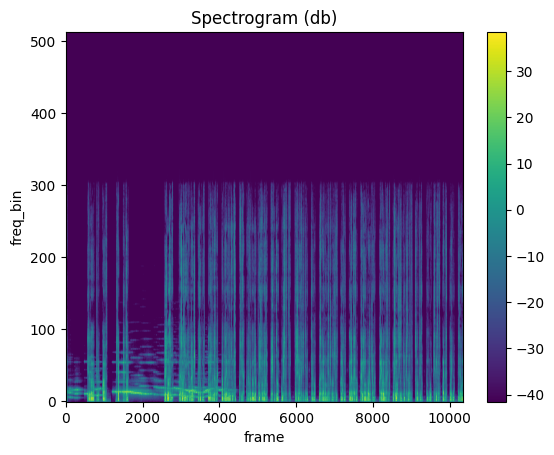

In [39]:
plot_spectrogram(signal_new)